<a href="https://colab.research.google.com/github/Tamimi123600/Deep-Learning/blob/main/Image_Segmentation_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation Task

In this notebook, we will create a U-Net model to perform semantic image segmentation.

## Importing dependencies 

In [ ]:
# importing operating system module
import os

# Data wrangling
import numpy as np 
import random
from zipfile import ZipFile

# Data visualization
import matplotlib.pyplot as plt
import cv2

# image processing packages
from skimage import io 

# Importing models and necessary layers
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, Activation, MaxPool2D, Concatenate

## Loading data

### Unzip main file and creating paths to directories

In [ ]:
#with ZipFile('/content/drive/MyDrive/Dataset.zip','r') as zip:
  #zip.extractall('/content/drive/MyDrive/Image Segmentation')

In [ ]:
# path to training directory
path = "/content/drive/MyDrive/Image Segmentation/cityscapes_data/train/"
# path to validation directory
path1 = "/content/drive/MyDrive/Image Segmentation/cityscapes_data/val/"


### Loading *training* folder 

In [ ]:
# returning a list of the images inside the training folder 
train_images = os.listdir(path)
# number of images cinside the training folder
print(f"Train directory has {len(train_images)} images.")

Train directory has 2975 images.


### Loading *validation* folder 

In [ ]:
# returning a list of the images inside the validation folder 
val_images = os.listdir(path1)
# number of images inside the training folder
print(f"Validation directory has {len(val_images)} images.")

Validation directory has 500 images.


## Analysing and Preprocessing data

### Training images

In [ ]:
# create a list to store in the file
train_images_list = []
for images in train_images:
  # read the images in the file
  image = io.imread(path + "/" + images)
  train_images_list.append(image)

In [ ]:
# convert list to array 
train_arr = np.array(train_images_list)

In [ ]:
train_arr.shape

(2975, 256, 512, 3)

Here, we have a total of 2975 files(images) in the training folder. Each image is 256 in height, 256 in width and has 3 channels. Let's visualise how a random image looks like

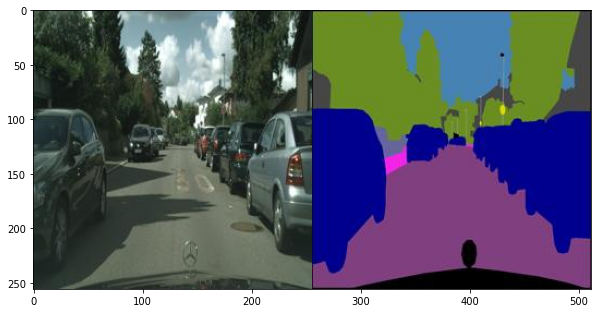

In [ ]:
plt.figure(figsize=(10,10))
random_image = random.randint(0,len(train_arr))
plt.imshow(train_arr[random_image])

This implies that we have to split the image pair to have an original image and its corresponding mask. Will split the image pair so that the original image and mask has a dimension of (256,256,3).

In [ ]:
# split the image pair, obtaining all images 
train_images = train_arr[:,:,0:256]
# split the image pair, obtaining all masks
train_masks = train_arr[:,:,256:512]

In [ ]:
# shape of original images after splitting
train_images.shape

(2975, 256, 256, 3)

In [ ]:
# shape of masks after splitting
train_masks.shape

(2975, 256, 256, 3)

For clarity and visualization, let's see how the images look like after splitting. Also, lets check if the image is sorted out with its mask. 

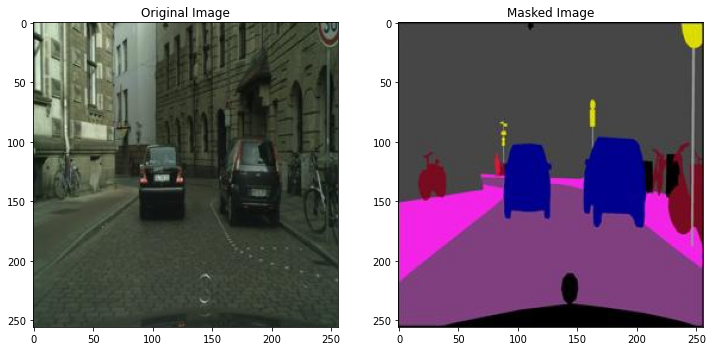

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(121)
plt.title('Original Image')
plt.imshow(train_images[0])
plt.subplot(122)
plt.title('Masked Image')
plt.imshow(train_masks[0])

Now lets check if the images need to be normalized.

In [ ]:
# max pixel in train_images
print(train_images.max())
# max pixel in val_images
print(train_masks.max())

255
255


Now that we know that the maximum pixel value in both images is 255, lets go ahead and normalize the pixels. 

In [ ]:
# normalizing train images
train_images = train_images/255
# normalizing train masks
train_masks = train_masks/255

### Validation images

All the preprocessing done for the training images will be done for the validation images.

In [ ]:
val_images_list = []
for images1 in val_images:
  image1 = io.imread(path1 + "/" + images1)
  val_images_list.append(image1)
# convert list to array 
val_arr = np.array(val_images_list)

In [ ]:
# split the image pair, obtaining all images 
val_images = val_arr[:,:,0:256]
# obtaining all the masks 
val_masks = val_arr [:,:,256:512]

In [ ]:
# normalization
val_images = val_images/255
val_masks = val_masks/255

Alright, so now that we have our training and validation directories ready we can go on and build our unet model. 

## Model 

Initialize some parameters.

In [ ]:
classes = 3
num_filters = 32
img_height = train_images.shape[1]
img_width = train_images.shape[2]
img_channels = train_images.shape[3]
input_shape = (img_height,img_width,img_channels)

### U-Net Model

In [ ]:
# Building Unet using encoder and decoder blocks
def conv_block(input, num_filters):
  # first conv layer
  x = Conv2D(num_filters, kernel_size = (3,3), padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # second conv layer
  x = Conv2D(num_filters, kernel_size= (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

def encoder_block(input, num_filters=64):
  # conv block
  x = conv_block(input,num_filters)
  # maxpooling 
  p = MaxPool2D(strides = (2,2))(x)
  p = Dropout(0.4)(p)
  return x,p

def decoder_block(input, skip_features, num_filters=64):
  x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

In [ ]:
def unet_architect(input_shape, classes):

  """ Input Layer """
  inputs = Input(input_shape)

  """ Encoder """
  s1,p1 = encoder_block(inputs, num_filters)
  s2,p2 = encoder_block(p1,num_filters *2) 
  s3,p3 = encoder_block(p2, num_filters *4) 
  s4,p4 = encoder_block(p3, num_filters * 8) 

  """ Bridge """
  b1 = conv_block(p4,num_filters*16)

  """ Decoder """ 
  d1 = decoder_block(b1, s4, num_filters * 8)
  d2 = decoder_block(d1, s3, num_filters *4)
  d3 = decoder_block(d2, s2, num_filters *2)
  d4 = decoder_block(d3, s1, num_filters)

  """ Output Layer """
  outputs = Conv2D(classes, (1,1), padding='same', activation = 'softmax')(d4)

  model = Model(inputs, outputs, name='U-Net')

  return model

In [ ]:
model = unet_architect(input_shape, classes)
model.compile(optimizer = 'adam' , 
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

#### Epochs = 5

In [ ]:
model1 =  model.fit(train_images, 
                    train_masks, 
                    batch_size= 18, 
                    validation_data = (val_images, val_masks),
                    epochs = 5)

Epoch 1/5
166/166 [==============================] - 49s 227ms/step - loss: 1.1355 - accuracy: 0.5387 - val_loss: 1.1376 - val_accuracy: 0.5307
Epoch 2/5
166/166 [==============================] - 35s 208ms/step - loss: 1.1199 - accuracy: 0.5947 - val_loss: 1.1267 - val_accuracy: 0.2538
Epoch 3/5
166/166 [==============================] - 35s 208ms/step - loss: 1.1161 - accuracy: 0.5683 - val_loss: 1.1010 - val_accuracy: 0.5539
Epoch 4/5
166/166 [==============================] - 35s 208ms/step - loss: 1.1113 - accuracy: 0.5780 - val_loss: 1.1017 - val_accuracy: 0.5771
Epoch 5/5
166/166 [==============================] - 34s 208ms/step - loss: 1.1086 - accuracy: 0.5792 - val_loss: 1.0850 - val_accuracy: 0.6383


In [ ]:
pred = model.predict(val_images)

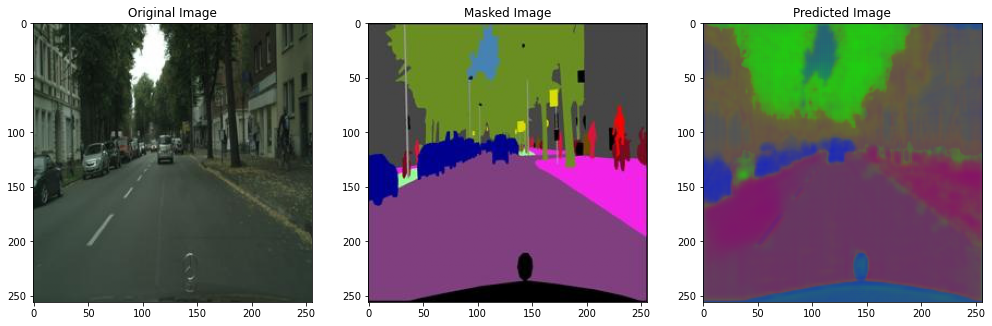

In [ ]:
random_img = random.randint(0, len(val_images))
original_img = val_images[random_img]
masked_img = val_masks[random_img]
prediction_img = pred[random_img]
plt.figure(figsize=(17,20))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(original_img)
plt.subplot(132)
plt.title('Masked Image')
plt.imshow(masked_img)
plt.subplot(133)
plt.title('Predicted Image')
plt.imshow((prediction_img)) 
plt.show()

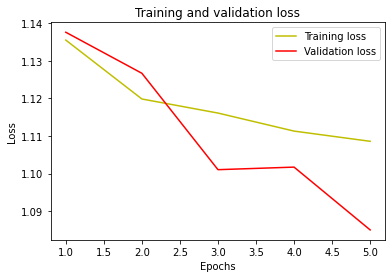

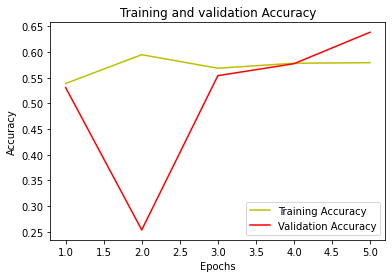

In [ ]:
loss = model1.history['loss']
val_loss = model1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = model1.history['accuracy']
val_acc = model1.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Epochs = 10

In [ ]:
model2 =  model.fit(train_images, 
                    train_masks, 
                    batch_size= 36, 
                    validation_data = (val_images, val_masks),
                    epochs = 10)

Epoch 1/10
83/83 [==============================] - 50s 458ms/step - loss: 1.1640 - accuracy: 0.5673 - val_loss: 1.9986 - val_accuracy: 0.5442
Epoch 2/10
83/83 [==============================] - 34s 406ms/step - loss: 1.1807 - accuracy: 0.6114 - val_loss: 1.2412 - val_accuracy: 0.3826
Epoch 3/10
83/83 [==============================] - 34s 406ms/step - loss: 1.1989 - accuracy: 0.6399 - val_loss: 1.3609 - val_accuracy: 0.5057
Epoch 4/10
83/83 [==============================] - 34s 406ms/step - loss: 1.2235 - accuracy: 0.6871 - val_loss: 1.3115 - val_accuracy: 0.5100
Epoch 5/10
83/83 [==============================] - 34s 406ms/step - loss: 1.2506 - accuracy: 0.6996 - val_loss: 1.4464 - val_accuracy: 0.5656
Epoch 6/10
83/83 [==============================] - 34s 406ms/step - loss: 1.2615 - accuracy: 0.6920 - val_loss: 1.3892 - val_accuracy: 0.6923
Epoch 7/10
83/83 [==============================] - 34s 406ms/step - loss: 1.2735 - accuracy: 0.6706 - val_loss: 1.2923 - val_accuracy: 0.5832

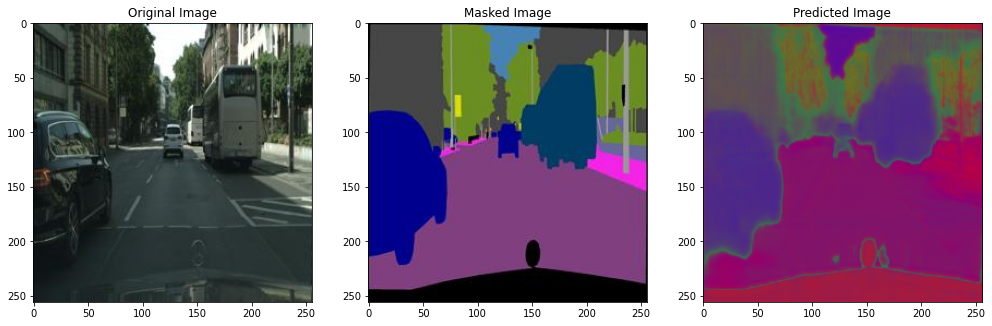

In [ ]:
pred1 = model.predict(val_images)
random_img = random.randint(0, len(val_images))
original_img1 = val_images[random_img]
masked_img1 = val_masks[random_img]
prediction_img1 = pred1[random_img]
plt.figure(figsize=(17,20))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(original_img1)
plt.subplot(132)
plt.title('Masked Image')
plt.imshow(masked_img1)
plt.subplot(133)
plt.title('Predicted Image')
plt.imshow((prediction_img1)) 
plt.show()

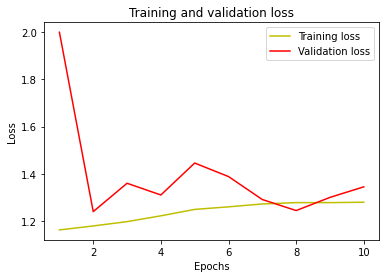

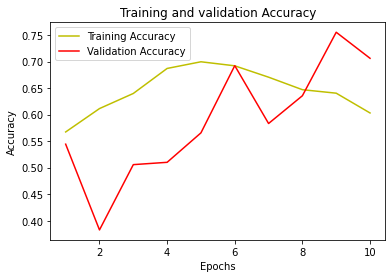

In [ ]:
loss = model2.history['loss']
val_loss = model2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = model2.history['accuracy']
val_acc = model2.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Epochs = 15

In [ ]:
model3 =  model.fit(train_images, 
                    train_masks, 
                    batch_size= 30, 
                    validation_data = (val_images, val_masks),
                    epochs = 15)

Epoch 1/15
100/100 [==============================] - 48s 363ms/step - loss: 1.1500 - accuracy: 0.5163 - val_loss: 1.1924 - val_accuracy: 0.3071
Epoch 2/15
100/100 [==============================] - 33s 331ms/step - loss: 1.1215 - accuracy: 0.5899 - val_loss: 1.2065 - val_accuracy: 0.3972
Epoch 3/15
100/100 [==============================] - 33s 331ms/step - loss: 1.1218 - accuracy: 0.6198 - val_loss: 1.2984 - val_accuracy: 0.5131
Epoch 4/15
100/100 [==============================] - 33s 331ms/step - loss: 1.1229 - accuracy: 0.6539 - val_loss: 1.1450 - val_accuracy: 0.6272
Epoch 5/15
100/100 [==============================] - 33s 331ms/step - loss: 1.1256 - accuracy: 0.6367 - val_loss: 1.1342 - val_accuracy: 0.6128
Epoch 6/15
100/100 [==============================] - 33s 331ms/step - loss: 1.1264 - accuracy: 0.6203 - val_loss: 1.2002 - val_accuracy: 0.6260
Epoch 7/15
100/100 [==============================] - 33s 330ms/step - loss: 1.1265 - accuracy: 0.6088 - val_loss: 1.1330 - val_ac

In [ ]:
pred2 = model.predict(val_images)

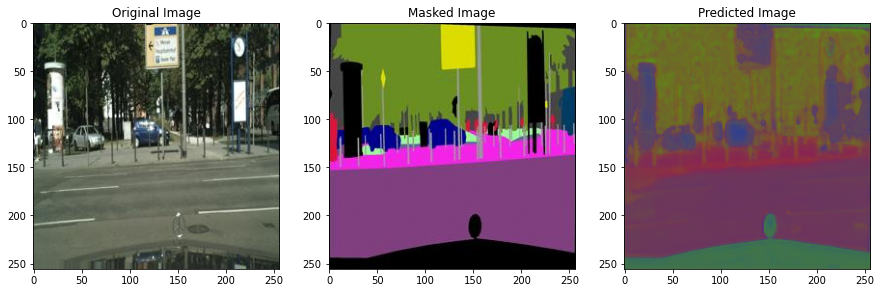

In [ ]:
random_img = random.randint(0, len(val_images))
original_img2 = val_images[random_img]
masked_img2 = val_masks[random_img]
prediction_img2 = pred2[random_img]
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(original_img2)
plt.subplot(132)
plt.title('Masked Image')
plt.imshow(masked_img2)
plt.subplot(133)
plt.title('Predicted Image')
plt.imshow((prediction_img2)) 
plt.show()

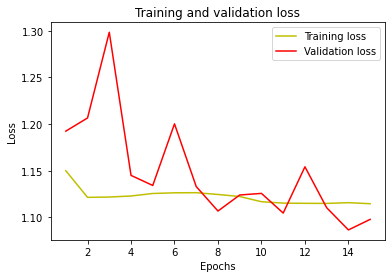

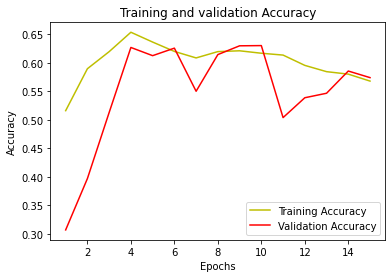

In [ ]:
loss = model3.history['loss']
val_loss = model3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = model3.history['accuracy']
val_acc = model3.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()